In [20]:
import pandas as pd
import scipy.stats
import numpy as np
import seaborn as sns
import os
import math

import plotly.express as pl
from matplotlib import pyplot as plt

import torch.optim
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor

from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox


import neuralsens.partial_derivatives as ns





In [2]:
cwd = os.getcwd()
data = pd.read_csv(cwd + '/datos_TFM_Celia.csv', sep = ',', engine='python')
data['Time'] = pd.to_datetime(data['Time'])

df_hist = data[data['Time'] < "2013-01-01 01:00:00"]
df_fut = data[data['Time'] > "2013-01-01 00:00:00"]

# Is it stationary?

In [3]:
fig = pl.line(df_hist, x = 'Time', y='Power')
fig.show()

In [4]:
# Augmented Dickey-Fuller test

X = df_hist.Power.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -16.874469
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


The null hypothesis is rejected, the series is stationary

Text(0.5, 1.0, 'Función de Autocorrelación Parcial')

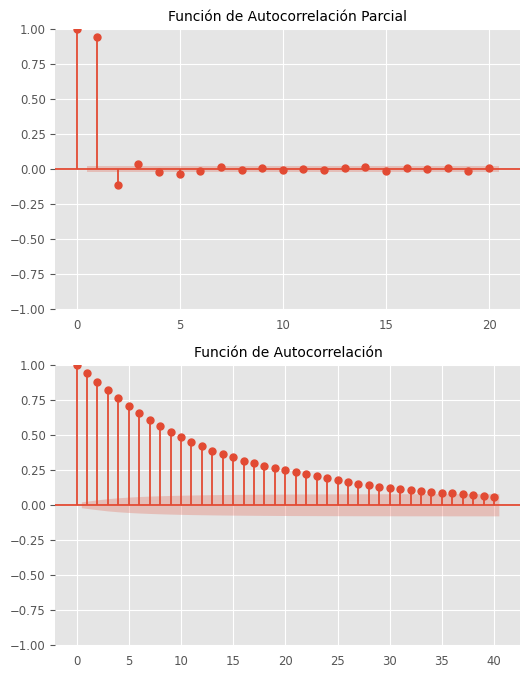

In [5]:
fig, axs = plt.subplots(2, figsize=(6, 8))

sm.graphics.tsa.plot_acf(df_hist.Power.values, lags=40, ax=axs[1])
axs[1].set_title('Función de Autocorrelación', fontsize=10)

sm.graphics.tsa.plot_pacf(df_hist.Power.values, lags=20, ax=axs[0])
axs[0].set_title('Función de Autocorrelación Parcial', fontsize=10)


In [6]:
horizon = 10
horizons = range(1, horizon+1)

# Naive

In [15]:
real_data = df_fut['Power'].values
predictions_list = []

for i in range(len(real_data)):
    last_real_value = real_data[i] if i < len(real_data) - 1 else real_data[-1]
    predictions = {h: last_real_value for h in horizons}
    predictions_list.append(predictions)

predictions_matrix_naive = pd.DataFrame(predictions_list)
predictions_matrix_naive.index = df_fut['Time'].values

naive_predictions_matrix = pd.DataFrame()
for i in range(horizon):
    shifted_predictions = predictions_matrix_naive.iloc[:, i].shift(i+1)
    naive_predictions_matrix[f'+{i+1}h'] = shifted_predictions

naive_predictions_matrix.index = df_fut['Time'].values
naive_predictions_matrix['Power'] = df_fut['Power']

naive_predictions_matrix

,+1h,+2h,+3h,+4h,+5h,+6h,+7h,+8h,+9h,+10h,Power
2013-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.117376
2013-01-01 02:00:00,0.117376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.137675
2013-01-01 03:00:00,0.137675,0.117376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.160605
2013-01-01 04:00:00,0.160605,0.137675,0.117376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.192463
2013-01-01 05:00:00,0.192463,0.160605,0.137675,0.117376,NaN,NaN,NaN,NaN,NaN,NaN,0.187388
...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 14:00:00,0.142938,0.044075,0.076591,0.074993,0.079974,0.049713,0.069354,0.110516,0.149516,0.110046,0.274598
2013-12-31 15:00:00,0.274598,0.142938,0.044075,0.076591,0.074993,0.079974,0.049713,0.069354,0.110516,0.149516,0.453623
2013-12-31 16:00:00,0.453623,0.274598,0.142938,0.044075,0.076591,0.074993,0.079974,0.049713,0.069354,0.110516,0.555587
2013-12-31 17:00:00,0.555587,0.453623,0.274598,0.142938,0.044075,0.076591,0.074993,0.079974,0.049713,0.069354,0.719575


# ARIMA (1,1,1)

In [25]:
# Ajustar el modelo ARIMA inicial con datos históricos
historical_data = df_hist['Power'].values
initial_model = sm.tsa.arima.ARIMA(historical_data, order=(1,1,1))
fitted_model = initial_model.fit()
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8784
Model:                 ARIMA(1, 1, 1)   Log Likelihood                8170.840
Date:                Thu, 06 Jun 2024   AIC                         -16335.681
Time:                        19:44:26   BIC                         -16314.439
Sample:                             0   HQIC                        -16328.444
                               - 8784                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3220      0.064     -5.040      0.000      -0.447      -0.197
ma.L1          0.4131      0.062      6.713      0.000       0.292       0.534
sigma2         0.0091   6.79e-05    134.129      0.0

In [26]:
residuals = fitted_model.resid

# Realizar el Test de Ljung-Box en los residuos
ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)

print("Resultados del Test de Ljung-Box:")
print(ljung_box_test)

Resultados del Test de Ljung-Box:
      lb_stat     lb_pvalue
10  62.955192  9.957397e-10


In [10]:
real_data = df_fut['Power'].values
predictions_list = []

for i in range(len(real_data)):
    updated_model = fitted_model.append(pd.Series(real_data[i]), refit=True)  # Actualizar el modelo 

    predictions = {}
    for h in horizons:
        forecast_results = updated_model.get_forecast(steps=h)
        predictions[h] = forecast_results.predicted_mean[-1]  # Última predicción

    predictions_list.append(predictions)
    fitted_model = updated_model

predictions_matrix = pd.DataFrame(predictions_list)
predictions_matrix.index = df_fut['Time'].values


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt

In [11]:
arima_predictions_matrix = pd.DataFrame()
for i in range(horizon):
    # Para cada horizonte, desplazamos los valores hacia abajo en 'i' posiciones
    shifted_predictions = predictions_matrix.iloc[:, i].shift(i+1)
    arima_predictions_matrix[f'+{i+1}h'] = shifted_predictions

arima_predictions_matrix.index = predictions_matrix.index
df_fut.index = df_fut['Time']
arima_predictions_matrix['Power'] = df_fut['Power']
arima_predictions_matrix


,+1h,+2h,+3h,+4h,+5h,+6h,+7h,+8h,+9h,+10h,Power
2013-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.117376
2013-01-01 02:00:00,0.068788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.137675
2013-01-01 03:00:00,0.160994,0.085917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.160605
2013-01-01 04:00:00,0.152349,0.152773,0.079878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.192463
2013-01-01 05:00:00,0.198977,0.155260,0.155671,0.082007,NaN,NaN,NaN,NaN,NaN,NaN,0.187388
...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 14:00:00,0.150692,0.042548,0.077168,0.074001,0.081679,0.049192,0.068447,0.108206,0.150483,0.112050,0.274598
2013-12-31 15:00:00,0.279811,0.147639,0.042158,0.077122,0.073967,0.081657,0.049190,0.068449,0.108204,0.150482,0.453623
2013-12-31 16:00:00,0.463166,0.277759,0.148841,0.042311,0.077140,0.073981,0.081665,0.049191,0.068448,0.108205,0.555587
2013-12-31 17:00:00,0.557995,0.459409,0.278567,0.148368,0.042251,0.077133,0.073975,0.081662,0.049190,0.068449,0.719575


## Compara con Naive

In [16]:
naive_predictions_matrix.dropna(inplace=True)
arima_predictions_matrix.dropna(inplace=True)

error_list = []

for i in horizons:
    column_name = f'+{i}h'
    mae_a = mean_absolute_error(arima_predictions_matrix['Power'], arima_predictions_matrix[column_name])
    rmse_a = math.sqrt(mean_squared_error(arima_predictions_matrix['Power'], arima_predictions_matrix[column_name]))
    mae_n = mean_absolute_error(naive_predictions_matrix['Power'], naive_predictions_matrix[column_name])
    rmse_n = math.sqrt(mean_squared_error(naive_predictions_matrix['Power'], naive_predictions_matrix[column_name]))
    error_list.append({'Horizon': i, 'MAE ARIMA': mae_a, 'MAE NAIVE': mae_n, 'RMSE ARIMA': rmse_a,  'RMSE NAIVE': rmse_n})

# Convertir la lista de diccionarios a DataFrame
df_comp_error = pd.DataFrame(error_list)

df_comp_error['MAE Best'] = df_comp_error.apply(lambda row: 'ARIMA' if (row['MAE ARIMA'] < row['MAE NAIVE']) else 'NAIVE', axis=1)
df_comp_error['RMSE Best'] = df_comp_error.apply(lambda row: 'ARIMA' if (row['RMSE ARIMA'] < row['RMSE NAIVE']) else 'NAIVE', axis=1)

df_comp_error

,Horizon,MAE ARIMA,MAE NAIVE,RMSE ARIMA,RMSE NAIVE,MAE Best,RMSE Best
0,1,0.062783,0.063049,0.098915,0.098958,ARIMA,ARIMA
1,2,0.094253,0.094343,0.142682,0.142632,ARIMA,NAIVE
2,3,0.117331,0.117400,0.173641,0.173518,ARIMA,NAIVE
3,4,0.136805,0.136833,0.198771,0.198627,ARIMA,NAIVE
4,5,0.153772,0.153742,0.220223,0.220086,NAIVE,NAIVE
5,6,0.169019,0.168902,0.239197,0.238993,NAIVE,NAIVE
6,7,0.182228,0.182138,0.255358,0.255151,NAIVE,NAIVE
7,8,0.193810,0.193701,0.269984,0.269733,NAIVE,NAIVE
8,9,0.204542,0.204478,0.282787,0.282536,NAIVE,NAIVE
9,10,0.214804,0.214634,0.294338,0.294027,NAIVE,NAIVE


In [17]:
horizonte_prediccion = 1
column_name = f'+{horizonte_prediccion}h'


df_resultados = arima_predictions_matrix.copy()
df_resultados['Time'] = df_resultados.index
df_resultados['ARIMA'] = df_resultados[column_name]
df_resultados['Naive'] = df_fut['Power'].shift(horizonte_prediccion)
df_resultados['Producción Real'] = df_resultados['Power']
#df_fut['ARIMA'] = arima_predictions_matrix[column_name].values
fig = pl.line(df_resultados, x='Time', y=['Producción Real', 'ARIMA', 'Naive'])
fig.show()

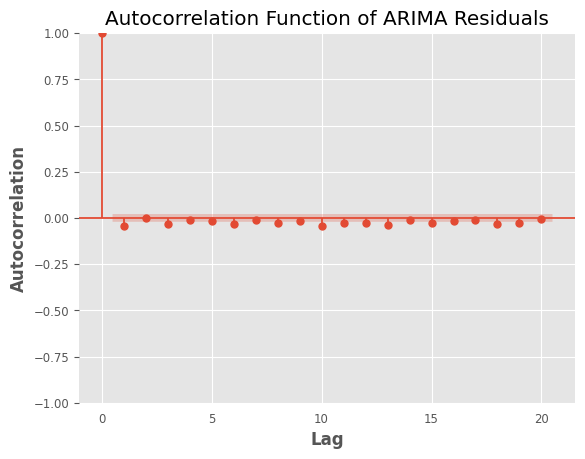

In [18]:
from statsmodels.graphics.tsaplots import plot_acf

# Obtener residuos del modelo MLP
residuals = df_resultados['Power'] - df_resultados['ARIMA']

# Calcular la función de autocorrelación de los residuos
plot_acf(residuals, lags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function of ARIMA Residuals')
plt.show()


# ARIMA (2,1,0)

In [19]:
# Ajustar el modelo ARIMA inicial con datos históricos
historical_data = df_hist['Power'].values
initial_model_2 = sm.tsa.arima.ARIMA(historical_data, order=(2,1,0))
fitted_model_2 = initial_model_2.fit()
print(fitted_model_2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8784
Model:                 ARIMA(2, 1, 0)   Log Likelihood                8178.394
Date:                Thu, 06 Jun 2024   AIC                         -16350.788
Time:                        18:18:08   BIC                         -16329.546
Sample:                             0   HQIC                        -16343.551
                               - 8784                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0851      0.006     13.413      0.000       0.073       0.098
ar.L2         -0.0671      0.007     -9.258      0.000      -0.081      -0.053
sigma2         0.0091   6.83e-05    133.042      0.0

In [21]:
residuals = fitted_model_2.resid

# Realizar el Test de Ljung-Box en los residuos
ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)

print("Resultados del Test de Ljung-Box:")
print(ljung_box_test)


Resultados del Test de Ljung-Box:
      lb_stat     lb_pvalue
10  55.770686  2.266255e-08


In [ ]:
real_data = df_fut['Power'].values
predictions_list = []

for i in range(len(real_data)):
    updated_model = fitted_model_2.append(pd.Series(real_data[i]), refit=True)  # Actualizar el modelo 

    predictions = {}
    for h in horizons:
        forecast_results = updated_model.get_forecast(steps=h)
        predictions[h] = forecast_results.predicted_mean[-1]  # Última predicción

    predictions_list.append(predictions)
    fitted_model_2 = updated_model

predictions_matrix_2 = pd.DataFrame(predictions_list)
predictions_matrix_2.index = df_fut['Time'].values

In [ ]:
arima_predictions_matrix_2 = pd.DataFrame()
for i in range(horizon):
    # Para cada horizonte, desplazamos los valores hacia abajo en 'i' posiciones
    shifted_predictions = predictions_matrix_2.iloc[:, i].shift(i+1)
    arima_predictions_matrix_2[f'+{i+1}h'] = shifted_predictions

arima_predictions_matrix_2.index = predictions_matrix_2.index
df_fut.index = df_fut['Time']
arima_predictions_matrix_2['Power'] = df_fut['Power']
arima_predictions_matrix_2

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Obtener residuos del modelo MLP
residuals = df_resultados['Power'] - df_resultados['ARIMA']

# Calcular la función de autocorrelación de los residuos
plot_acf(residuals, lags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function of ARIMA Residuals')
plt.show()

## Compara con ARIMA(1,1,1) y Naive

In [ ]:
arima_predictions_matrix_2.dropna(inplace=True)

error_list = []

for i in horizons:
    column_name = f'+{i}h'
    mae_a = mean_absolute_error(arima_predictions_matrix['Power'], arima_predictions_matrix[column_name])
    rmse_a = math.sqrt(mean_squared_error(arima_predictions_matrix['Power'], arima_predictions_matrix[column_name]))
    mae_n = mean_absolute_error(naive_predictions_matrix['Power'], naive_predictions_matrix[column_name])
    rmse_n = math.sqrt(mean_squared_error(naive_predictions_matrix['Power'], naive_predictions_matrix[column_name]))
    mae_a2 = mean_absolute_error(arima_predictions_matrix_2['Power'], arima_predictions_matrix_2[column_name])
    rmse_a2 = math.sqrt(mean_squared_error(arima_predictions_matrix_2['Power'], arima_predictions_matrix_2[column_name]))
    error_list.append({'Horizon': i, 'MAE v1': mae_a, 'MAE v2': mae_a2, 'MAE NAIVE': mae_n, 'RMSE v1': rmse_a, 'RMSE v2': rmse_a2,  'RMSE NAIVE': rmse_n})

# Convertir la lista de diccionarios a DataFrame
df_comp_error = pd.DataFrame(error_list)

df_comp_error['MAE Best'] = df_comp_error.apply(lambda row: 'v1' if (row['MAE v1'] < row['MAE v2']) and (row['MAE v1'] < row['MAE NAIVE']) else ('v2' if (row['MAE v2'] < row['MAE NAIVE']) else 'Naive'), axis=1)
df_comp_error['RMSE Best'] = df_comp_error.apply(lambda row: 'v1' if (row['RMSE v1'] < row['RMSE v2']) and (row['RMSE v1'] < row['RMSE NAIVE']) else ('v2' if (row['RMSE v2'] < row['RMSE NAIVE']) else 'Naive'), axis=1)

df_comp_error

In [ ]:
df_comp_error.to_csv('ARIMA_Resultados.csv', index=False)

# Otros

In [ ]:
# Ajustar el modelo ARIMA inicial con datos históricos
historical_data = df_hist['Power'].values
initial_model_2 = sm.tsa.arima.ARIMA(historical_data, order=(1,1,0))
fitted_model_2 = initial_model_2.fit()
print(fitted_model_2.summary())